Lanthaler, Martin, Clemens Dlaska, Kilian Ender, and Wolfgang Lechner. 2023. “Rydberg-Blockade-Based Parity Quantum Optimization.” Physical Review Letters 130 (22): 220601. https://doi.org/10.1103/PhysRevLett.130.220601.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx import gnm_random_graph
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

from qubovert.utils import solve_qubo_bruteforce as qubo_solver


import pulser
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice, MockDevice  
from pulser.waveforms import InterpolatedWaveform, BlackmanWaveform

import sys
sys.path.append('..')

from source.qubo import solve_qubo_bruteforce, plot_distribution, anneal, draw_solutions, evaluate_mapping, get_Q_from_coords, get_register_embedding
from source.qubovert_custom import problem_to_qubo_matrix
from source.helpers import matprint
from itertools import combinations

from dataclasses import replace

from pulser.channels.dmm import DMM
from pulser.devices import AnalogDevice
from pulser.register import Register
from pulser.register.register_layout import RegisterLayout
from pulser.register.mappable_reg import MappableRegister
from pulser.register.weight_maps import DetuningMap
from pulser.sampler import sampler
from pulser.sequence import Sequence
from pulser.pulse import Pulse
from pulser.waveforms import ConstantWaveform, RampWaveform
from pulser.waveforms import InterpolatedWaveform
from pulser_simulation import QutipEmulator

### 3BODY
Left: Normal version with additional weights $a$, $b$, $c$ from compensation of long range vdW tails.   
3BODY represents $n_a \oplus n_b \oplus n_c = 1$. ($\oplus$ addition mod 2), i.e. (100, 010, 001, 111)


![Screenshot 2025-03-31 093839.png](<attachment:Screenshot 2025-03-31 093839.png>)
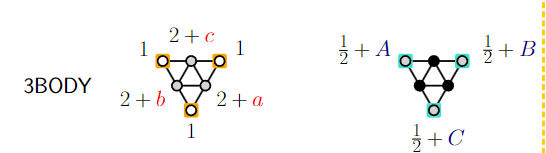

In [ ]:
def get_triangle_coords_tip_down(tip_pos, side_length):
    """constraint graph """
    coords = [tip_pos]
    height = side_length * np.sqrt(3) / 2
    coords.append((tip_pos[0] - side_length/2, tip_pos[1] + height))
    coords.append((tip_pos[0] + side_length/2, tip_pos[1] + height))

    return np.array(coords)

def get_triangle_coords_tip_up(tip_pos, side_length):
    """constraint graph
    tip_pos: position of the tip of the triangle (x, y)
    """
    coords = [tip_pos]
    height = side_length * np.sqrt(3) / 2
    coords.append((tip_pos[0] - side_length/2, tip_pos[1] - height))
    coords.append((tip_pos[0] + side_length/2, tip_pos[1] - height))

    return np.array(coords)

def get_3BODY_coords_tip_down(tip_pos, side_length):
    """ consists of a triangle with tip down and a triangle with tip up inside of it, half the side length"""
    coords = get_triangle_coords_tip_down(tip_pos, side_length)
    height = side_length * np.sqrt(3) / 2
    coords_inner = get_triangle_coords_tip_up([tip_pos[0], tip_pos[1] + height], side_length/2.)
    coords = np.vstack((coords, coords_inner))
    return coords

def get_3BODY_coords_tip_up(tip_pos, side_length):
    """ consists of a triangle with tip up and a triangle with tip down inside of it, half the side length"""
    coords = get_triangle_coords_tip_up(tip_pos, side_length)
    height = side_length * np.sqrt(3) / 2
    coords_inner = get_triangle_coords_tip_down([tip_pos[0], tip_pos[1] - height], side_length/2.)
    coords = np.vstack((coords, coords_inner))
    return coords

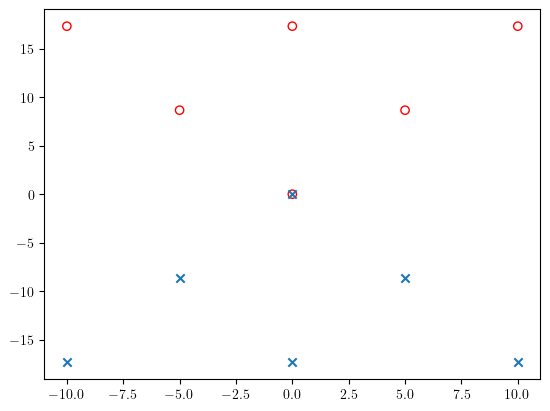

In [375]:
coords = get_3BODY_coords_tip_down((0, 0), 20)
plt.scatter(coords[:, 0], coords[:, 1], marker='o', facecolors='none', edgecolors='r')
coords = get_3BODY_coords_tip_up((0, 0), 20)
plt.scatter(coords[:, 0], coords[:, 1], marker='x')

Pulse integral: 3.14096427386


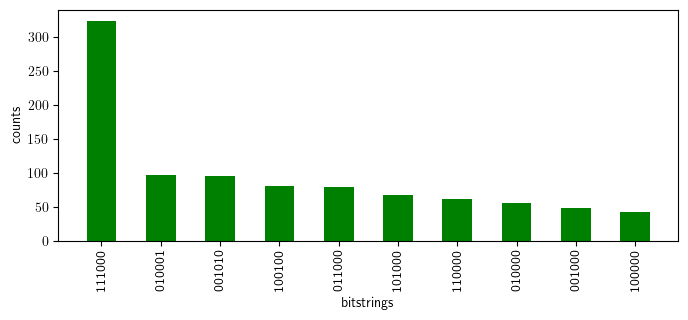

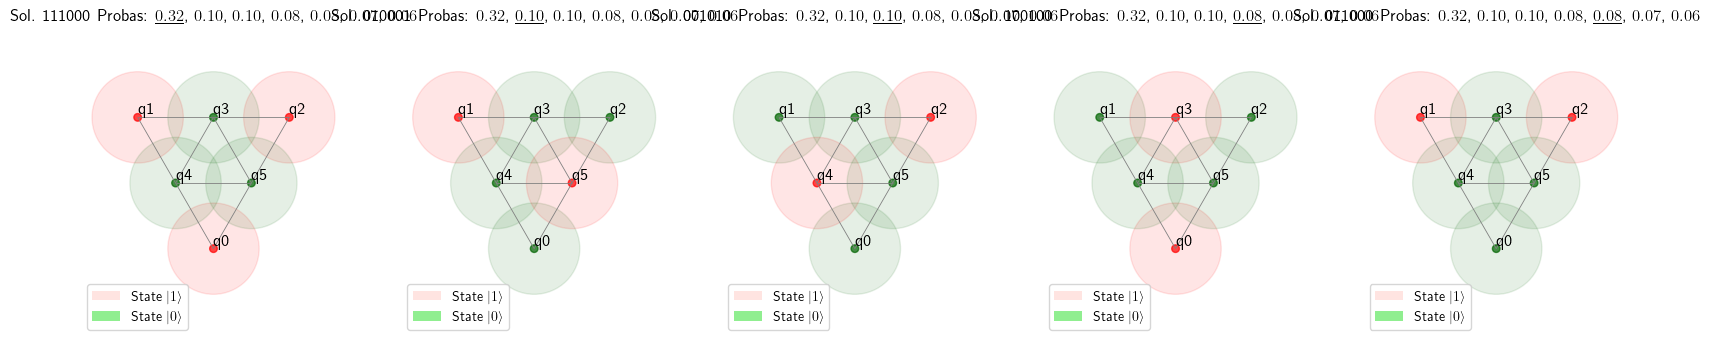

In [4]:
coords = get_3BODY_coords_tip_down((0, 0), 22)
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)

T = 5000
Omega = 1.5*np.pi * 1000./T
delta_i = -2.
delta_f = -delta_i
counts = anneal(reg, Omega, delta_i, delta_f, T=T, draw_distribution=True)
draw_solutions(reg, counts, n=5, draw_graph=True)

We see that the different solutions don't have the same probabilities, because we did not fix the weights of the inner nodes.

Very difficult to tune the weights here. I don't know why this set of values works well, but it does

{'dmm_0': DMM(addressing='Global', max_abs_detuning=None, max_amp=0, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=67108864, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=None, propagation_dir=None, bottom_detuning=-125.66370614359172, total_bottom_detuning=-25132.741228718343), 'dmm_1': DMM(addressing='Global', max_abs_detuning=None, max_amp=0, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=1, min_duration=1, max_duration=100000000, min_avg_amp=0, mod_bandwidth=None, custom_phase_jump_time=None, eom_config=None, propagation_dir=None, bottom_detuning=None, total_bottom_detuning=None)}
{'dmm_0': DMM(addressing='Global', max_abs_detuning=None, max_amp=0, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=67108864, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=None, propag

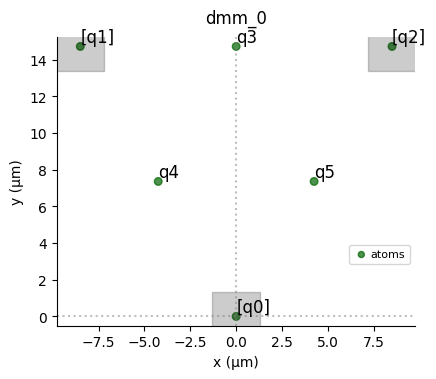

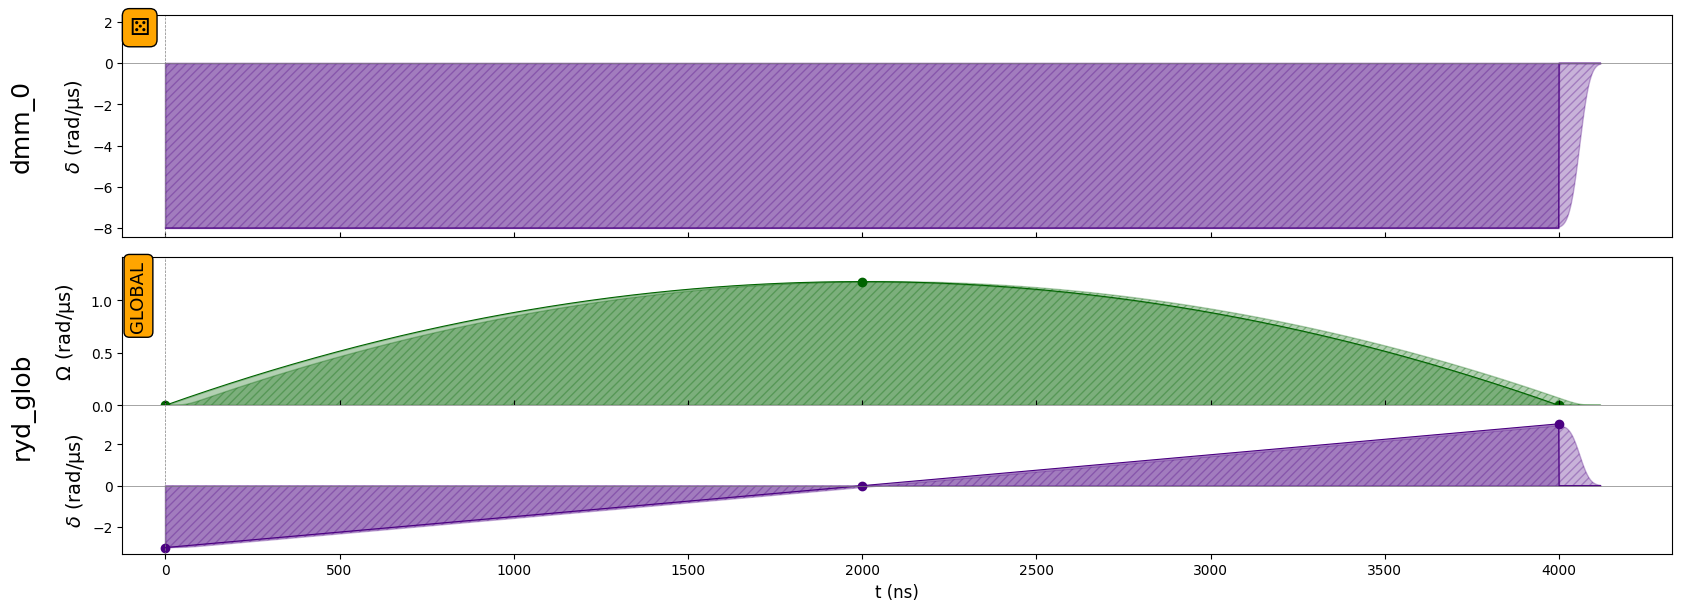

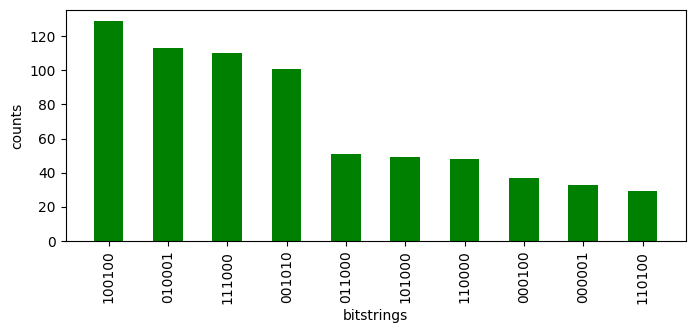

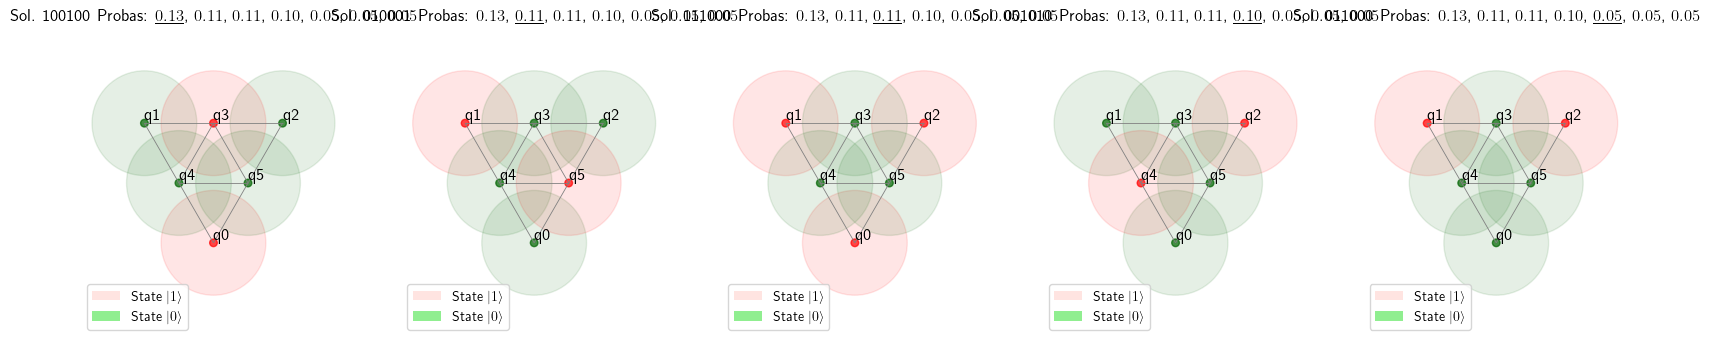

In [257]:
plt.rc("text", usetex=False)  # latex error in register.draw else
coords = get_3BODY_coords_tip_down((0, 0), 17)
# dd = np.pi/np.abs(detuning_val) # how much detuning to apply to each trap
detuning_val = -8. # detuning between 0 and -20 MHz
dd = 1./20.
T = 4000
Omega = 1.5 * np.pi * 1000. / T
delta_i = -3.0
delta_f = -delta_i
# detuning_weights = [0.0, dd, 0.0, dd, dd, 0.0]
detuning_weights = [dd, 0.0, dd, 0.0, 0.0, dd]

register_layout = RegisterLayout(coords)
detuning_map = register_layout.define_detuning_map(
    {i: detuning_weights[i] for i in range(6)}  # mapping between trap ids and weights
)

register = Register.from_coordinates(
    coords, center=False, prefix="q"
)

dmm = DMM(
    clock_period=4,
    min_duration=16,
    max_duration=2**26,
    mod_bandwidth=8,
    bottom_detuning=-2 * np.pi * 20,  # detuning between 0 and -20 MHz
    total_bottom_detuning=-2 * np.pi * T,  # total detuning
)
mock_device = replace(
    AnalogDevice.to_virtual(),
    dmm_objects=(dmm, DMM()),
    reusable_channels=True,
)

seq = Sequence(register, mock_device)
seq.config_detuning_map(detuning_map, "dmm_0")
print(mock_device.dmm_channels)
print(seq.declared_channels)

seq.add_dmm_detuning(ConstantWaveform(T, detuning_val), "dmm_0") # detuning between 0 and -20 MHz. Multiply by above weights

adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_i, 0, delta_f]),
    0,
)

seq.declare_channel("ryd_glob", "rydberg_global")
seq.add(adiabatic_pulse, "ryd_glob", protocol="no-delay")
seq.draw(draw_detuning_maps=True)

simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()
plot_distribution(count_dict, show=True)

draw_solutions(register, count_dict, n=5, draw_graph=True, show=True, Omega=Omega)

### 4BODY
3BODY represents $n_a \oplus n_b \oplus n_c \oplus n_c = 0$. ($\oplus$ addition mod 2), i.e. (0000, 1100, ..., 1111)


In [546]:
def is_odd(x):
    if x & 1:
        return 'odd'
    else:
        return 'even'

# 4 body consists of a triangle with tip down and a triangle with tip up. Same side lengths. Linked at the tip
def get_4BODY_coords_tip_down(tip_pos, side_length, link_length:int=0):
    """constraint graph """
    if not (link_length == 0) and not is_odd(link_length):
        raise ValueError(f"Link length must be 0 or odd, got {link_length}")
    coords_up = get_3BODY_coords_tip_up(tip_pos, side_length)

    sep = side_length
    if link_length == 0:
        coords_down = get_3BODY_coords_tip_down(tip_pos, side_length)
        coords_down = coords_down[1:]
        return np.vstack((coords_up, coords_down))
    tip_pos = (tip_pos[0], tip_pos[1] + (link_length + 1) * sep / 2)
    coords_down = get_3BODY_coords_tip_down(tip_pos, side_length)
    link_coords = np.array([[tip_pos[0], tip_pos[1] - (i + 1) * sep / 2] for i in range(link_length)])
    return np.vstack((coords_up, coords_down, link_coords))

Pulse integral: 3.1408071585540003


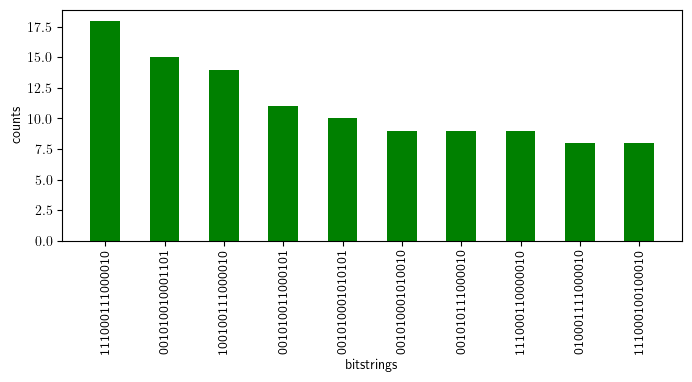

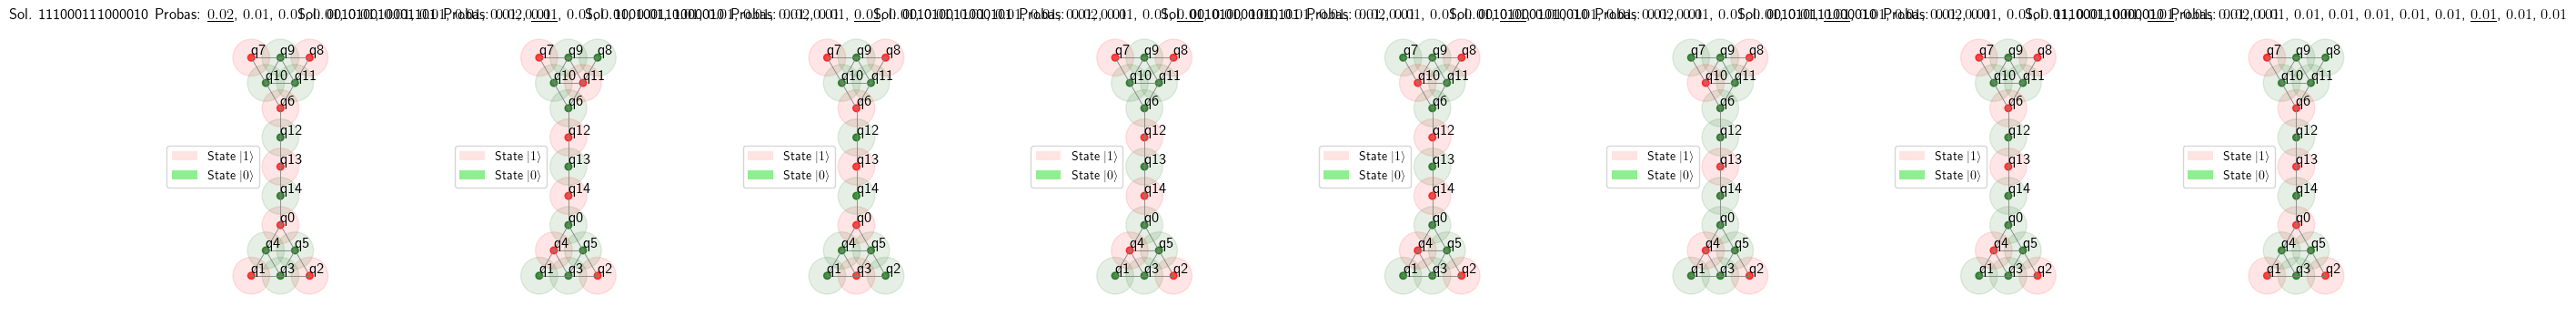

In [550]:
coords = get_4BODY_coords_tip_down((0, -15), 21, link_length=3)
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)

T = 4000
Omega = 1.5*np.pi * 1000./T
delta_i = -5.0
delta_f = -delta_i
counts = anneal(reg, Omega, delta_i, delta_f, T=T, draw_distribution=True)
draw_solutions(reg, counts, n=8, draw_graph=True)

array([[  0.        , -15.        ],
       [-10.5       , -33.18653348],
       [ 10.5       , -33.18653348],
       [  0.        , -33.18653348],
       [ -5.25      , -24.09326674],
       [  5.25      , -24.09326674],
       [  0.        ,  27.        ],
       [-10.5       ,  45.18653348],
       [ 10.5       ,  45.18653348],
       [  0.        ,  45.18653348],
       [ -5.25      ,  36.09326674],
       [  5.25      ,  36.09326674],
       [  0.        ,  16.5       ],
       [  0.        ,   6.        ],
       [  0.        ,  -4.5       ]])

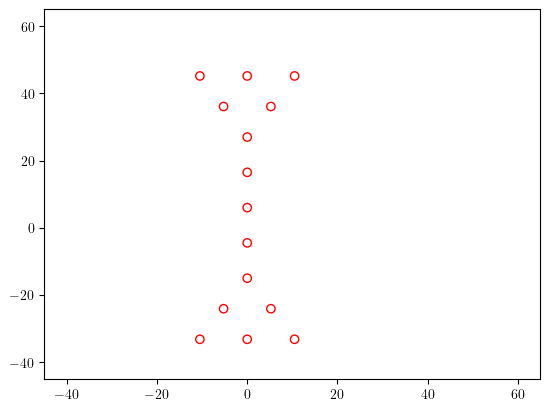

In [547]:
coords = get_4BODY_coords_tip_down((0, -15), 21, link_length=3)
plt.scatter(coords[:, 0], coords[:, 1], marker='o', facecolors='none', edgecolors='r')
plt.xlim(-45, 65)
plt.ylim(-45, 65)
coords